In [7]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.environ['DH_DIR'])
sys.path.append('..')

import numpy as np
from scipy import integrate

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('../matplotlibrc')

In [8]:
import darkhistory.physics as phys
from utils import logspace

## Verify electron cooling rates

In [10]:
year = 365.25 * 86400 # [s]

def e_ics_rate(Eek, rs, *args): # [s^-1]([eV], [1])
    gamma = (Eek + phys.me)/phys.me
    tcool = 1e8 * year * (rs/10)**(-4) / gamma**2
    return 1/tcool

In [67]:
# verify fMCB
gamma = 1.3
beta = np.sqrt(1-1/(gamma**2))
T = 3e4
def f(c, p): # [eV^-3]([eV], [1]) | c stands for cos theta
    return (gamma * (1 - beta*c)) / (8*np.pi*T**3*1.20206 * (np.exp(gamma*(p-beta*p*c)/T) - 1)) * p**2 * 2 * np.pi
integrate.dblquad(f, 0, 100*T, -1, 1)

(0.9999974237222726, 3.630757468012312e-10)

In [144]:
gamma = 10
beta = np.sqrt(1-1/(gamma**2))
def test(pu, c):
    return (-beta*(((pu+1)/pu)*np.log(2*pu+1)-2)*c + (2*pu-np.log(2*pu+1)))

test_vals = np.zeros((100,100))
for i, pu in enumerate(np.logspace(-3, 3, 100)):
    for j, c in enumerate(np.linspace(-1, 1, 100)):
        test_vals[i,j] = test(pu, c)

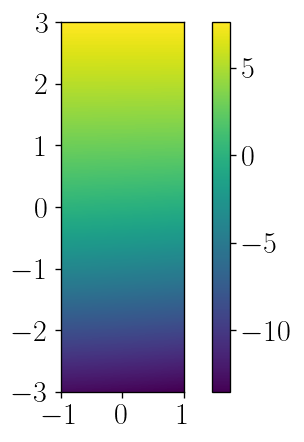

In [145]:
plt.imshow(np.flipud(np.log(test_vals)), extent=(-1, 1, -3, 3))
plt.colorbar()

In [126]:
def e_ics_cooling_rate(Eek, rs): # [s^-1]([eV], [1])
    Ee = Eek + phys.me
    gamma = Ee/phys.me
    beta = np.sqrt(1-1/(gamma**2))
    T = phys.TCMB(rs)
    
    def fCMB(p, c): # [eV^-3]([eV], [1]) | c stands for cos theta
        return (gamma * (1 - beta*c)) / (8*np.pi*T**3*1.20206 * (np.exp(gamma*(p-beta*p*c)/T) - 1))
    def integrand(c, p):
        pu = p/phys.me
        return (-beta*(((pu+1)/pu)*np.log(2*pu+1)-2)*c + (2*pu-np.log(2*pu+1))) * fCMB(p, c) * p**2 * 2*np.pi
    intg = integrate.dblquad(integrand, 0, np.inf, -1, 1)#[0]
    xsec = phys.thomson_xsec / (2*Ee/phys.me) * gamma * np.array(intg)
    rate = phys.CMB_N_density(phys.TCMB(rs)) * xsec * beta * phys.c
    return rate

In [127]:
phys.TCMB(10000)

2.3486539456199997

In [128]:
e_ics_cooling_rate(1e6, 1e4)

<ipython-input-126-ba6045521a49>:8: RuntimeWarning: overflow encountered in exp
  return (gamma * (1 - beta*c)) / (8*np.pi*T**3*1.20206 * (np.exp(gamma*(p-beta*p*c)/T) - 1))
<ipython-input-126-ba6045521a49>:8: RuntimeWarning: overflow encountered in double_scalars
  return (gamma * (1 - beta*c)) / (8*np.pi*T**3*1.20206 * (np.exp(gamma*(p-beta*p*c)/T) - 1))


array([1.42953599e-08, 2.35994376e-08])

In [129]:
rs = 5

Eeks = logspace(1e3, 1e9, 30)
rates1 = e_ics_rate(Eeks, rs)
rates2 = np.zeros_like(rates1)
for i, Eek in enumerate(tqdm(Eeks)):
    rates2[i] = e_ics_cooling_rate(Eek, rs)[0]

  0%|          | 0/30 [00:00<?, ?it/s]

<ipython-input-126-ba6045521a49>:8: RuntimeWarning: overflow encountered in exp
  return (gamma * (1 - beta*c)) / (8*np.pi*T**3*1.20206 * (np.exp(gamma*(p-beta*p*c)/T) - 1))


In [130]:
rates2

array([-4.46681958e-22, -9.10570240e-22, -1.85354048e-21, -3.76431289e-21,
       -7.61658686e-21, -1.53203232e-20, -3.05282153e-20, -5.99409027e-20,
       -1.15022353e-19, -2.13131969e-19, -3.74939176e-19, -6.12363410e-19,
       -9.04111924e-19, -1.17569351e-18, -1.32751136e-18, -1.31398934e-18,
       -1.17141329e-18, -9.62008827e-19, -7.36623265e-19, -5.34708985e-19,
       -3.65447217e-19, -2.27577959e-19, -1.29850785e-19, -7.06868782e-20,
       -3.77005348e-20, -2.16797058e-20, -1.32044122e-20, -6.07495668e-21,
       -1.51257488e-21, -1.28304247e-22])

[]

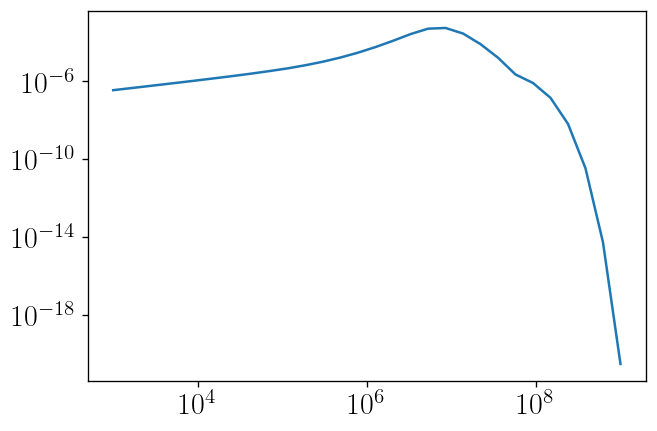

In [123]:
plt.plot(Eeks, np.abs(rates2))
plt.loglog()

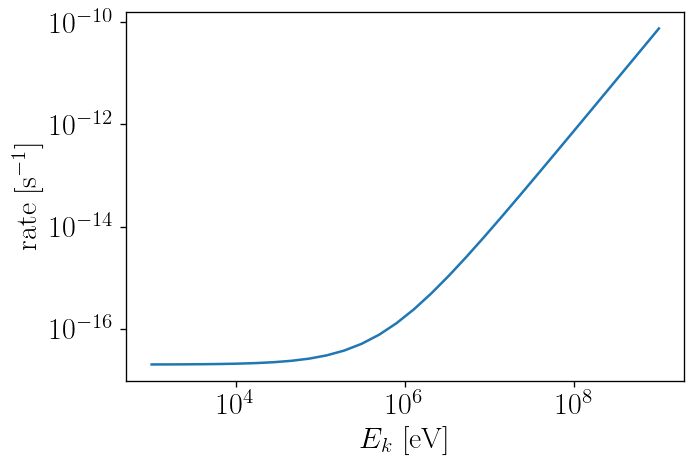

In [21]:
fig, ax = plt.subplots()
ax.plot(Eeks, rates1)
ax.plot(Eeks, rates2)
ax.set(xscale='log', yscale='log')
ax.set(xlabel=r'$E_k$ [eV]', ylabel='rate [s$^{-1}$]');